# **온라인 쇼핑몰 리뷰 분류하기**


- **온라인 쇼핑몰 리뷰 데이터**
  - 일반적으로 온라인 쇼핑몰에는 구입한 제품에 대한 텍스트 리뷰와 평점을 남길 수 있는 시스템이 마련되어 있다. 본 데이터는 한 아마존에서 특정일에 판매된 제품 전반에 대한 서로 다른 리뷰를 수집하고 고객의 개인정보 없이 공개한 데이터입니다. 온라인 쇼핑몰을 이용한 고객이 남긴 데이터이며, 총 2,501개의 샘플로 구성되어 있다.

  - 데이터 주요 열(column) 이해하기
    - category : 상품 카테고리    ex) Foods
    - report_date : 리뷰 작성일    ex) 2019-01-02
    - review_rating : 평점    ex) 5
    - review_text : 리뷰 텍스트    ex) A great flavour top - up for slow cooking.

## **0. RNN과 LSTM**

- 시계열(Time Sequential) 데이터를 학습하는 경우, 이전 과거의 값을 바탕으로 현재의 값을 예측하는 모델이 필요함
- 순환신경망(RNN; Recurrent Neural Network)
    - 인공신경망 중 은닉층의 출력 결과가 다시 같은 은닉층의 입력으로 들어가도록 연결되어 있는 것
    - 시퀀스 데이터를 처리하는 데에 강점을 보임
    - RNN 모델의 활용

        <img src="https://i.stack.imgur.com/b4sus.jpg" width=400>

- RNN 모델의 구조

    - <img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FqkLoA%2FbtqR9lSIHSo%2F5568lwMxBAQNzHLYrKC3k0%2Fimg.png" width=400>
    - <img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Feg8JHS%2FbtqSjBfRtXP%2Fg3tMpzJPKKfe21AiRxd8Ik%2Fimg.png" width=400>

        - h_(t-1) = W_(t-1)*x_(t-1) + b_(t-1)
        - h_t = W_xh * x_t + W_hh * h_(t-1) + b_t
        - y_t = W_hy * tanh(h_t) + b_t


- RNN 모델의 문제점
    - RNN은 길이가 긴 시퀀스에서 앞쪽 시점의 정보가 먼 거리에 있는 시점까지 충분히 전달되지 못하는 문제가 있음. 이러한 문제를 해결하기 위해 LSTM(Long Short Term Memory)이 고안됨.
    - ex) "*The earth* is a great place to live. However, this beautiful *place* is facing the problem of environmental pollution."

- LSTM(Long Short-term Memory)과 GRU(Gated Recurrent Unit)

    <img src="https://miro.medium.com/v2/resize:fit:1194/1*B0q2ZLsUUw31eEImeVf3PQ.png" width=500>

    - LSTM:
        - 이전 시점의 정보를 다음 시점으로 전달할 때, 어떤 정보를 잊어버릴지(short term) 또는 유지하여 전달할지(long term) 결정하는 연산을 함.
    - GRU:
        - 과거와 현재의 정보를 각각 얼마나 반영할지에 대한 비율을 구하는 연산을 함.
        - LSTM 모델과 비교하여 학습할 파라미터 수가 더 적음.
        


## **1. 문제정의**

- 온라인 쇼핑몰에서 구입한 제품에 대한 고객의 만족도를 파악하려면 어떻게 해야할까요? 바로 고객의 리뷰 데이터를 분석해야합니다! 고객이 구매한 제품과 텍스트 리뷰, 평점 수치에 대한 통찰력을 얻고 부정적인 리뷰에서 쇼핑몰을 개선되는 점을 찾는 것입니다. 상품 카테고리 별 리뷰의 긍정도를 파악하고, 평점의 분포를 확인하는 등 리뷰 데이터를 이해하고, **리뷰 텍스트를 기반으로 평점 값을 예측하는 딥러닝 모델을 만들어봅니다.**

## **2. 데이터수집**


[데이터 출처](https://www.kaggle.com/datasets/akudnaver/amazon-reviews-dataset)

In [ ]:
# numpy, pandas, matplotlib, seaborn 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/My Drive/Colab Notebooks/.kaggle'

In [ ]:
# 데이터셋 다운로드
!kaggle datasets download -d akudnaver/amazon-reviews-dataset

  0% 0.00/1.46M [00:00<?, ?B/s]
100% 1.46M/1.46M [00:00<00:00, 131MB/s]


In [ ]:
!unzip amazon-reviews-dataset.zip

Archive:  amazon-reviews-dataset.zip
  inflating: review-details.xlsx     


In [ ]:
# 온라인 쇼핑몰 데이터프레임(df) 생성하기
df = pd.read_excel('./review-details.xlsx')

# 첫행부터 5개 행의 데이터 확인하기
df.head()

,report_date,online_store,upc,retailer_product_code,brand,category,sub_category,product_description,review_date,review_rating,...,dimension2,dimension3,dimension4,dimension5,dimension6,dimension7,dimension8,verified_purchase,helpful_review_count,review_hash_id
0,2019-01-02,FRESHAMAZON,8718114216478,B0142CI6FC,Dove Men+Care,Personal Care,Deos,Dove Men+Care Extra Fresh Anti-perspirant Deod...,2019-01-01,5,...,Male Anti-Perspirant Deodorant,COTC Male Anti-Perspirant Deodorant,NaN,NaN,NaN,COTC Male Anti-Perspirant Deodorant,Core of the Core,True,0,3f129b02-ea76-0323-bd59-235d97a4f83f
1,2019-01-03,FRESHAMAZON,5000184201199,B014DFNNRY,Marmite,Foods,Savoury,Marmite Spread Yeast Extract 500g,2019-01-02,5,...,COTC Yeast Extract,COTC Yeast Extract,NaN,NaN,NaN,COTC Yeast Extract,Core of the Core,True,0,d7f3b9aa-e8b3-626d-683b-374e201c8315
2,2019-01-03,FRESHAMAZON,5000184201199,B014DFNNRY,Marmite,Foods,Savoury,Marmite Spread Yeast Extract 500g,2019-01-02,4,...,COTC Yeast Extract,COTC Yeast Extract,NaN,NaN,NaN,COTC Yeast Extract,Core of the Core,True,0,e58a523d-0155-a366-f107-7ac6817ac3b7
3,2019-01-03,FRESHAMAZON,8712566479726,B014DFKELC,Knorr,Foods,Savoury,Knorr Beef Stock Pot 8 x 28g,2019-01-02,5,...,Beef Stock/Pots/Cubes/Extract/Liquid/Concentrated,Stock Pots,NaN,NaN,NaN,Stock Pots,Core of the Core,True,0,aaa9bb87-4f99-bb89-65cb-3b400ebb45c0
4,2019-01-03,FRESHAMAZON,8717163536476,B014G37I7E,Cif,Homecare,HHC,Cif Citrus Bathroom Mousse 500ml,2019-01-02,5,...,Bathroom Mousse,Bathroom Mousse,NaN,NaN,NaN,NaN,Core of the Core,False,0,48c71b34-d7fe-5e90-51dd-239e153fb0ae


In [ ]:
# 데이터프레임 요약정보 보기
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2501 entries, 0 to 2500
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   report_date             2501 non-null   datetime64[ns]
 1   online_store            2501 non-null   object        
 2   upc                     2501 non-null   int64         
 3   retailer_product_code   2501 non-null   object        
 4   brand                   2501 non-null   object        
 5   category                2501 non-null   object        
 6   sub_category            2501 non-null   object        
 7   product_description     2501 non-null   object        
 8   review_date             2501 non-null   datetime64[ns]
 9   review_rating           2501 non-null   int64         
 10  review_title            2403 non-null   object        
 11  review_text             2501 non-null   object        
 12  is_competitor           2501 non-null   int64   

## **3. 탐색적 데이터 분석(EDA)**

In [ ]:
# 시각화 라이브러리 import
import seaborn as sns
import matplotlib.pyplot as plt

##### **필요한 열만 골라 데이터프레임 생성하기**

In [ ]:
# 필요한 열만 골라 데이터프레임 생성하기
data = df[['review_rating','category','review_text']]

In [ ]:
# 첫행부터 5개 행의 데이터 확인하기
data.head()

,review_rating,category,review_text
0,5,Personal Care,"As you get older, you know what you like and w..."
1,5,Foods,Three gigantic marmite jars that will last pro...
2,4,Foods,Excellent
3,5,Foods,A great flavour top - up for slow cooking.
4,5,Homecare,Does what is says it does


### 3.1. 평점 별 점수 비율 알아보기

In [ ]:
# 평점 별 개수가 많은 순으로 확인하기
data['review_rating'].value_counts().sort_values(ascending=False)

5    1848
4     319
1     146
3     107
2      81
Name: review_rating, dtype: int64

  - 이번에는 파이차트를 통해 평점 별 비율을 확인해봅시다.

<Axes: ylabel='review_rating'>

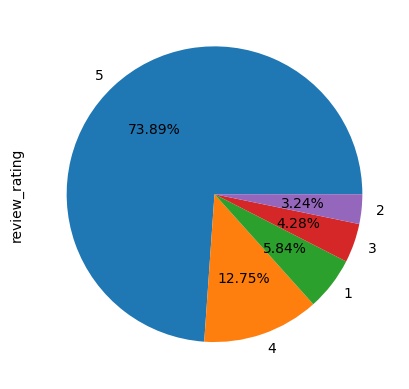

In [ ]:
# 평점 별 비율을 파이차트로 확인하기
data['review_rating'].value_counts().sort_values(ascending=False).plot(kind='pie', autopct='%.2f%%')

<Axes: xlabel='review_rating', ylabel='count'>

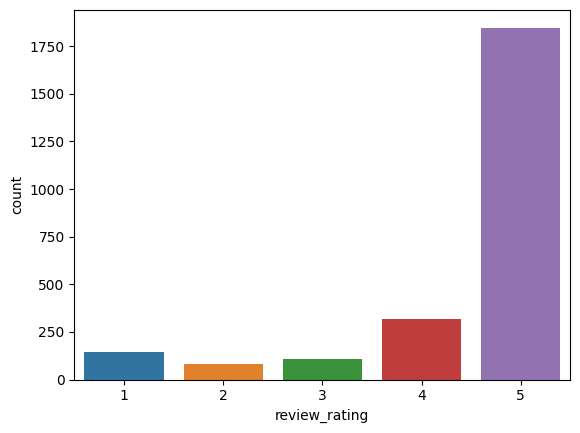

In [ ]:
# 평점 별 개수를 막대그래프로 확인하기
sns.countplot(x='review_rating', data= data)

### 3.2. 상품 카테고리 별 평점 알아보기

<Axes: xlabel='category', ylabel='count'>

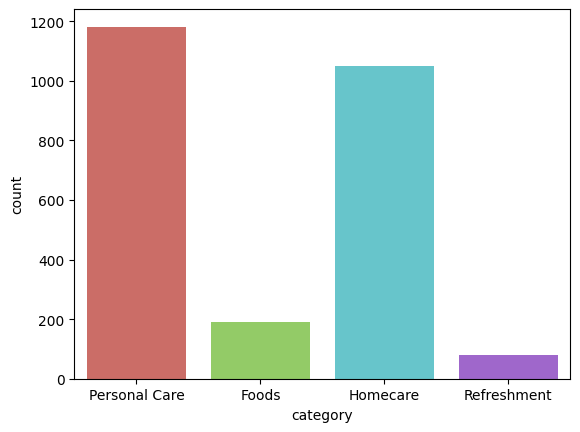

In [ ]:
# 상품 카테고리 별 데이터 개수 확인하기
sns.countplot(x='category', data=data, palette='hls')

<Axes: xlabel='review_rating', ylabel='count'>

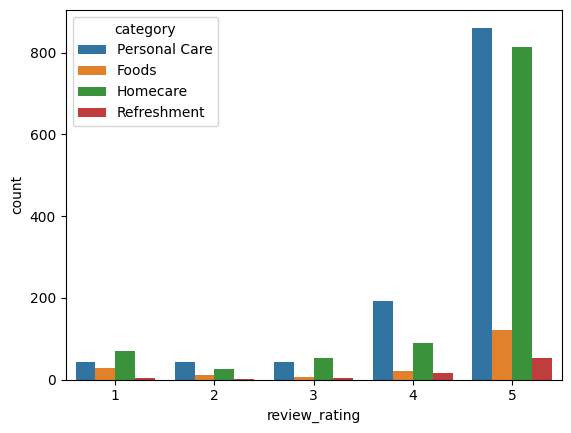

In [ ]:
# 상품 카테고리 별 평점 분포 확인하기
sns.countplot(x='review_rating', hue='category', data= data)

## **4. 데이터 전처리**

### 4.1. 상품 카테고리 값을 정수 값으로 인코딩하기

  - Pandas factorize()를 이용하면 카테고리형 데이터를 쉽게 정수형 데이터로 인코딩할 수 있음
  - Pandas get_dummies()를 이용하면 정수값을 원-핫 인코딩을 쉽게 할 수 있음

In [ ]:
# 카테고리 값을 정수로 변환하기
data['category'] = pd.factorize(data['category'])[0]
data.head()

<ipython-input-17-4a23a2b6050b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['category'] = pd.factorize(data['category'])[0]


,review_rating,category,review_text
0,5,0,"As you get older, you know what you like and w..."
1,5,1,Three gigantic marmite jars that will last pro...
2,4,1,Excellent
3,5,1,A great flavour top - up for slow cooking.
4,5,2,Does what is says it does


In [ ]:
# 정수로 변환된 카테고리 값을 원-핫 인코딩하기
data = pd.get_dummies(data,columns =['category'])
data.head()

,review_rating,review_text,category_0,category_1,category_2,category_3
0,5,"As you get older, you know what you like and w...",1,0,0,0
1,5,Three gigantic marmite jars that will last pro...,0,1,0,0
2,4,Excellent,0,1,0,0
3,5,A great flavour top - up for slow cooking.,0,1,0,0
4,5,Does what is says it does,0,0,1,0


### 4.2. 문장에서 구두점 삭제하기

In [ ]:
# 구두점 삭제 함수 정의
import string

def rem_punctuation(text):
    no_punc = "".join([x for x in text if x not in string.punctuation])
    return no_punc

In [ ]:
# 'review_text' 열에 구두점 삭제 함수 적용하기
data['review_text'] = data['review_text'].apply(lambda x: rem_punctuation(x))
data['review_text'].head()

0    As you get older you know what you like and wh...
1    Three gigantic marmite jars that will last pro...
2                                            Excellent
3             A great flavour top  up for slow cooking
4                            Does what is says it does
Name: review_text, dtype: object

### 4.3. 문장을 단어로 토큰화하기

- 특정 단위로 텍스트를 자르는 것을 '토큰화(Tokenization)'이라고 함. 텍스트을 자르는 단위를 '토큰(Token)'이라 하는데, 목적에 따라 토큰은 문자, 단어, 심지어는 문장이 될 수도 있음

In [ ]:
# 토크나이저 생성
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

In [ ]:
# 토크나이저 적용
data['review_text']  = data['review_text'].apply(lambda x: tokenizer.tokenize(x.lower()))
data['review_text'].head()

0    [as, you, get, older, you, know, what, you, li...
1    [three, gigantic, marmite, jars, that, will, l...
2                                          [excellent]
3     [a, great, flavour, top, up, for, slow, cooking]
4                     [does, what, is, says, it, does]
Name: review_text, dtype: object

In [ ]:
data.head()

,review_rating,review_text,category_0,category_1,category_2,category_3
0,5,"[as, you, get, older, you, know, what, you, li...",1,0,0,0
1,5,"[three, gigantic, marmite, jars, that, will, l...",0,1,0,0
2,4,[excellent],0,1,0,0
3,5,"[a, great, flavour, top, up, for, slow, cooking]",0,1,0,0
4,5,"[does, what, is, says, it, does]",0,0,1,0


### 4.4. 평점 열을 기반으로 긍정/부정 평점 열 생성하기

In [ ]:
# 평점 긍정/부정을 의미하는 'Positivity' 열 생성하기
data.dropna(inplace=True)
data = data[data['review_rating'] != 3]
data['Positivity'] = np.where(data['review_rating']>3,1,0)
cols = ['review_rating']
data.drop(cols, axis=1, inplace=True)

<ipython-input-25-71450a778104>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Positivity'] = np.where(data['review_rating']>3,1,0)
<ipython-input-25-71450a778104>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(cols, axis=1, inplace=True)


In [ ]:
# 첫행부터 5개 행의 데이터 확인하기
data.head()

,review_text,category_0,category_1,category_2,category_3,Positivity
0,"[as, you, get, older, you, know, what, you, li...",1,0,0,0,1
1,"[three, gigantic, marmite, jars, that, will, l...",0,1,0,0,1
2,[excellent],0,1,0,0,1
3,"[a, great, flavour, top, up, for, slow, cooking]",0,1,0,0,1
4,"[does, what, is, says, it, does]",0,0,1,0,1


- **np.where()**
  - np.where(조건, 참값, 거짓값): 조건이 참인 경우 참값을 리턴하고, 조건이 거짓인 경우 거짓값을 리턴


<Axes: xlabel='Positivity', ylabel='count'>

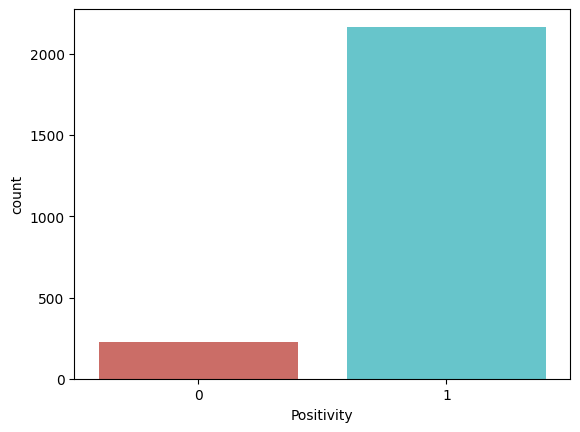

In [ ]:
# 'Positivity' 열 값의 분포를 막대그래프로 확인하기
sns.countplot(x='Positivity', data = data, palette = 'hls')

### 4.5. keras 라이브러리를 이용하여 데이터 전처리하기

- keras Tokenizer()를 이용하여 토큰화를 진행한다. 이때, filters 옵션 지정을 통해 제거할 구두점 및 특수기호를 정할 수 있다. lower 옵션을 True로 지정하면 토큰화를 진행하며 모든 알파벳을 소문자로 변환해준다.
- keras texts_to_sequences()를 이용하여 토큰화된 단어 리스트를 숫자 시퀀스로 변환한다.

In [ ]:
# keras 라이브러리에서 함수 불러오기
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, SimpleRNN, LSTM

In [ ]:
# keras 라이브러리를 이용하여 구두점 제거, 토큰화한 후 수치 시퀀스로 변환하기
MAX_NB_WORDS = 50000 # 사용할 단어의 최대 개수(최빈)
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['review_text'].values)

X = tokenizer.texts_to_sequences(data['review_text'].values)
print(X[:5])

[[11, 27, 105, 1119, 27, 291, 89, 27, 40, 1, 89, 10, 832, 13, 70, 114, 3, 40, 35, 184, 78, 389, 27, 26, 64, 35, 153, 1552, 1553, 85, 1, 52, 1001, 66, 1554, 12, 52, 905, 1555], [405, 1556, 723, 1002, 26, 55, 141, 467, 4, 200, 633, 89, 304, 46, 27, 1120, 522, 13, 374, 280, 14, 83, 62, 1121, 833, 771, 28, 125, 23, 6], [171], [4, 18, 242, 390, 54, 13, 1831, 1280], [92, 89, 10, 249, 6, 92]]


- pad_sequences()를 이용하여 패딩을 삽입함으로써 서로 다른 시퀀스 길이를 통일하겠습니다. 짧은 문장의 경우 시퀀스 내 빈 위치에 0값을 삽입합니다. 시퀀스의 길이는 가장 긴 시퀀스에 맞춰집니다.

In [ ]:
# 패딩을 삽입하여 시퀀스 길이 통일하기
X = pad_sequences(X)
print(X[:5])

[[   0    0    0 ...   52  905 1555]
 [   0    0    0 ...  125   23    6]
 [   0    0    0 ...    0    0  171]
 [   0    0    0 ...   13 1831 1280]
 [   0    0    0 ...  249    6   92]]


In [ ]:
# 변환된 X 데이터의 shape 확인하기
print(X.shape)

(2394, 285)


In [ ]:
# 토큰의 개수, X의 shape과 일부 확인하기
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print(X.shape[1])
print(X[:5])

Found 3860 unique tokens.
285
[[   0    0    0 ...   52  905 1555]
 [   0    0    0 ...  125   23    6]
 [   0    0    0 ...    0    0  171]
 [   0    0    0 ...   13 1831 1280]
 [   0    0    0 ...  249    6   92]]


In [ ]:
word_index

{'and': 1,
 'the': 2,
 'i': 3,
 'a': 4,
 'this': 5,
 'it': 6,
 'to': 7,
 'my': 8,
 'of': 9,
 'is': 10,
 'as': 11,
 'skin': 12,
 'for': 13,
 'in': 14,
 'was': 15,
 'have': 16,
 'on': 17,
 'great': 18,
 'product': 19,
 'so': 20,
 'but': 21,
 'good': 22,
 'with': 23,
 'not': 24,
 'use': 25,
 'that': 26,
 'you': 27,
 'very': 28,
 'part': 29,
 'review': 30,
 'love': 31,
 'promotion': 32,
 'collected': 33,
 'smell': 34,
 'all': 35,
 'really': 36,
 'are': 37,
 'these': 38,
 'its': 39,
 'like': 40,
 'using': 41,
 'they': 42,
 'be': 43,
 'well': 44,
 'value': 45,
 'would': 46,
 'nice': 47,
 'one': 48,
 'has': 49,
 'wash': 50,
 'buy': 51,
 'no': 52,
 'soft': 53,
 'up': 54,
 'will': 55,
 'dry': 56,
 'used': 57,
 'clean': 58,
 'after': 59,
 'at': 60,
 'face': 61,
 'when': 62,
 'wipes': 63,
 'fresh': 64,
 'me': 65,
 'or': 66,
 'smells': 67,
 'recommend': 68,
 'price': 69,
 'your': 70,
 'can': 71,
 'just': 72,
 'clothes': 73,
 'which': 74,
 'too': 75,
 'scent': 76,
 'lovely': 77,
 'products': 78,
 '

- 'Positivity' 열의 값을 바탕으로 원핫 인코딩하여 학습 레이블인 Y을 생성하겠습니다. 'Positivity' 값이 0인 경우 [1, 0], 1인 경우 [0, 1] 값으로 원핫 변환됩니다.

In [ ]:
# 출력층 활성화 함수를 sigmoid로 하는 경우
Y = data['Positivity']

In [ ]:
# 출력층 활성화 함수를 softmax로 하는 경우
# get_dummies()를 이용하여 'Positivity' 열 원핫 인코딩한 후, Y에 저장하기
# Y = pd.get_dummies(data['Positivity']).values
# print(Y[:5])

In [ ]:
# 훈련데이터와 테스트데이터 분리하기
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2,
                                                    random_state = 42,
                                                    stratify=Y)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1915, 285) (1915,)
(479, 285) (479,)


## **5. 모델정의**

#### 5.1. 모델 정의를 위한 변수 설정하기

In [ ]:
# RNN 모델 정의를 위한 변수 초기화하기
MAX_NB_WORDS = 50000                # 사용할 단어의 최대 개수(최빈)
MAX_SEQUENCE_LENGTH = X.shape[1]    # 가장 긴 시퀀스 길이
EMBEDDING_DIM = 150                 # 임베딩 차원 정의
rnn_out = 200                       # RNN층 unit 개수

#### 5.2. LSTM 모델 정의하기

##### **LSTM 모델 정의**
  - 학습 데이터의 shape을 기반으로 임베딩 층을 추가합니다.
  - keras의 LSTM()을 이용하여 LSTM 층을 추가합니다.
  - 출력 데이터의 형태를 고려하여 출력층을 추가합니다. 이때, 활성화 함수는 소프트맥스(softmax) 함수로 합니다.
  - RNN, LSTM 모델에서는 일반적으로 relu 함수를 사용하지 않는다.
    - Time Sequential하게 과거의 데이터를 지속적으로 꺼내서 사용하는 과정에서 과거의 값들이 끊임없이 재귀(반복적으로)로 사용되기때문에, -1~1 사이로 normalizing이 필요합니다.
    - relu를 사용할 경우 값이 발산할 확률이 아주아주 높아진다.
    - 1~1 사이로 normalizing해줄 수 있는 softmax 혹은 tanh가 주로 사용된다.


In [ ]:
# LSTM 모델 정의하기
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
# model.add(SimpleRNN(rnn_out, dropout=0.2, recurrent_dropout=0.2))
model.add((LSTM(rnn_out,dropout = 0.2,recurrent_dropout=0.2)))
# model.add(Dense(2, activation='softmax'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 285, 150)          7500000   
                                                                 
 lstm (LSTM)                 (None, 200)               280800    
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 7,781,001
Trainable params: 7,781,001
Non-trainable params: 0
_________________________________________________________________


## **6. 모델 학습**

##### **LSTM 모델 학습**


In [ ]:
# RNN모델 학습
history = model.fit(X_train, Y_train,
                    validation_data = (X_test, Y_test),
                    epochs = 10, batch_size=32, verbose = 2)

Epoch 1/10
60/60 - 94s - loss: 0.2973 - accuracy: 0.9013 - val_loss: 0.2144 - val_accuracy: 0.9165 - 94s/epoch - 2s/step
Epoch 2/10
60/60 - 83s - loss: 0.1386 - accuracy: 0.9525 - val_loss: 0.1712 - val_accuracy: 0.9395 - 83s/epoch - 1s/step
Epoch 3/10
60/60 - 81s - loss: 0.0659 - accuracy: 0.9796 - val_loss: 0.1396 - val_accuracy: 0.9582 - 81s/epoch - 1s/step
Epoch 4/10
60/60 - 81s - loss: 0.0323 - accuracy: 0.9885 - val_loss: 0.1660 - val_accuracy: 0.9415 - 81s/epoch - 1s/step
Epoch 5/10
60/60 - 78s - loss: 0.0219 - accuracy: 0.9948 - val_loss: 0.1769 - val_accuracy: 0.9436 - 78s/epoch - 1s/step
Epoch 6/10
60/60 - 75s - loss: 0.0065 - accuracy: 0.9995 - val_loss: 0.1986 - val_accuracy: 0.9624 - 75s/epoch - 1s/step
Epoch 7/10
60/60 - 75s - loss: 0.0047 - accuracy: 0.9990 - val_loss: 0.2580 - val_accuracy: 0.9624 - 75s/epoch - 1s/step
Epoch 8/10
60/60 - 74s - loss: 0.0054 - accuracy: 0.9990 - val_loss: 0.2275 - val_accuracy: 0.9478 - 74s/epoch - 1s/step
Epoch 9/10
60/60 - 73s - loss: 0

## **7. 모델 평가**

### 7.1. 테스트 데이터를 입력하여 모델 평가하기

In [ ]:
# model.evaluate로 모델 평가하기
accuracy = model.evaluate(X_test, Y_test)
print('테스트 데이터\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accuracy[0],accuracy[1]))

15/15 [==============================] - 2s 114ms/step - loss: 0.2659 - accuracy: 0.9395
테스트 데이터
  Loss: 0.266
  Accuracy: 0.939


### 7.2. 테스트 데이터 기반 Loss, Acc 그래프 평가하기

In [ ]:
# history 딕셔너리의 key 값 확인하기
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

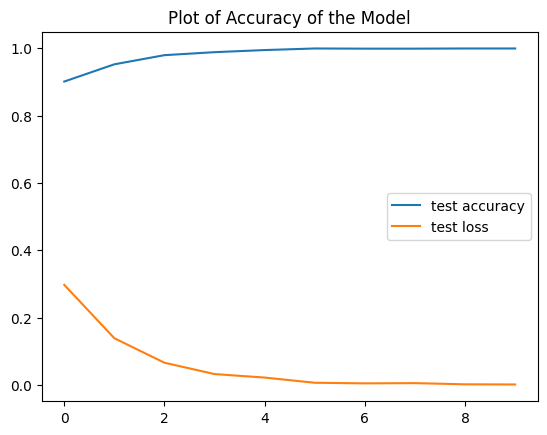

In [ ]:
# 테스트 데이터 손실(Loss)과 정확도(Accuracy)를 그래프로 나타내기
plt.title('Plot of Accuracy of the Model')
plt.plot(history.history['accuracy'], label='test accuracy')
plt.plot(history.history['loss'], label='test loss')
plt.legend()
plt.show()

## **8. 모델 활용**

### 8.1. 새로운 문장을 입력하여 모델 평가하기

In [ ]:
def model_test(new_review):
    seq = tokenizer.texts_to_sequences(new_review)
    print(seq)
    padded = pad_sequences(seq,maxlen = 285)
    pred = model.predict(padded)
    labels = {0: 'Negative', 1: 'Positive'}
    # print(labels[np.argmax(pred)])
    print(labels[int(np.round(pred, 0))])

In [ ]:
# 긍정 예시문을 대입하여 모델 활용하기
# 긍정예시1) i like the product and i wish to buy again
test_review = []
test_review.append(input())
model_test(test_review)

i like the product and i wish to buy again
[[3, 40, 2, 19, 1, 3, 522, 7, 51, 96]]
1/1 [==============================] - 0s 325ms/step
Positive


In [ ]:
# 긍정예시2) what a beautiful product i would like to recommend this to my friend
test_review = []
test_review.append(input())
model_test(test_review)

what a beautiful product i would like to recommend this to my friend
[[89, 4, 438, 19, 3, 46, 40, 7, 68, 5, 7, 8, 574]]
1/1 [==============================] - 0s 84ms/step
Positive


In [ ]:
# 부정 예시문을 대입하여 모델 활용하기
# 부정예시1) taste hard and so horrible
test_review = []
test_review.append(input())
model_test(test_review)

taste hard and so horrible
[[292, 299, 1, 20, 913]]
1/1 [==============================] - 0s 89ms/step
Negative




[참고자료](https://www.kaggle.com/code/akudnaver/fork-of-lstm-amazon-sentimental-analysis)